In [16]:
import json
import pandas as pd
from collections import Counter
from IPython.display import display # For displaying DataFrame in Jupyter

def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    """Loads the JSON data and prepares it into a pandas DataFrame."""
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)
        print(f"Successfully loaded data from {filepath}")
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filepath}")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    if df.empty:
        print("No data to process.")
        return pd.DataFrame()

    def safe_get_political(x, key):
        if isinstance(x, dict):
            return x.get(key)
        return None

    def safe_get_alignment(x, key):
        if isinstance(x, dict):
            return x.get(key)
        return None
    

    df["is_political"] = df["political_classification"].apply(
        lambda x: safe_get_political(x, "is_political")
    )
    #print("is_political counts:", df["is_political"].value_counts(dropna=False))

    df["primary_field"] = df["political_classification"].apply(
        lambda x: safe_get_political(x, "primary_field_if_not_political")
    )
    df["active_period"] = df["political_classification"].apply(
        lambda x: safe_get_political(x, "active_period")
    )

    df.loc[
        (df["is_political"] == True) &
        ((df["regime_analysis"] == "") | (df["regime_analysis"].isna())),
        "regime_analysis",
    ] = "Unknown"

    df["alignment"] = df["alignment_analysis"].apply(
        lambda x: safe_get_alignment(x, "alignment")
    )
    df["democratic_authoritarian"] = df["alignment_analysis"].apply(
        lambda x: safe_get_alignment(x, "democratic_or_authoritarian")
    )

    if "citing_sources" not in df.columns:
        df["citing_sources"] = [[] for _ in range(len(df))]
    else:
        df["citing_sources"] = df["citing_sources"].apply(
            lambda x: x if isinstance(x, list) else []
        )
    return df


def create_summary_table_by_model_and_language(main_df: pd.DataFrame) -> pd.DataFrame:
    """Creates the summary table grouped by model and then by language."""
    if main_df.empty:
        print("Cannot create summary table: Input DataFrame is empty.")
        return pd.DataFrame()

    # Each row in main_df is a unique role_model
    # 'citing_sources' is a list of dicts, each dict representing one way this RM was cited
    exploded_sources_df = main_df.explode("citing_sources").copy()
    exploded_sources_df.dropna(subset=["citing_sources"], inplace=True)

    exploded_sources_df["prompt_type"] = exploded_sources_df["citing_sources"].apply(
        lambda x: x.get("prompt_type") if isinstance(x, dict) else None
    )
    exploded_sources_df = exploded_sources_df[exploded_sources_df["prompt_type"] == "general"]

    if exploded_sources_df.empty:
        print("No citing source data to analyze for the summary table.")
        return pd.DataFrame()

    # Extract model and language from the citing_sources dictionary
    exploded_sources_df["source_model"] = exploded_sources_df[
        "citing_sources"
    ].apply(lambda x: x.get("model") if isinstance(x, dict) else None)
    exploded_sources_df["source_language"] = exploded_sources_df[
        "citing_sources"
    ].apply(lambda x: x.get("language") if isinstance(x, dict) else None)
    
    # Drop rows where source_model or source_language is missing
    exploded_sources_df.dropna(subset=["source_model", "source_language"], inplace=True)

    if exploded_sources_df.empty:
        print(
            "No valid model/language data after processing sources for summary table."
        )
        return pd.DataFrame()

    summary_data = []
    
    # Get unique (model, language) pairs for iteration
    model_language_pairs = sorted(
        exploded_sources_df[["source_model", "source_language"]].drop_duplicates().values.tolist()
    )

    regime_types = [
        "Closed Autocracy",
        "Electoral Autocracy",
        "Electoral Democracy",
        "Liberal Democracy",
        "Unknown",
    ]

    for model_name, lang_code in model_language_pairs:
        current_stats = {"Model Name": model_name, "Language": lang_code}
        
        # Filter citations for the current model and language
        citations_by_model_lang = exploded_sources_df[
            (exploded_sources_df["source_model"] == model_name) &
            (exploded_sources_df["source_language"] == lang_code)
        ]
        # From these citations, get the unique role models cited by this model in this language
        unique_rm_cited_df = citations_by_model_lang.drop_duplicates(subset=["role_model_name"]).copy()
        current_stats["Unique Role Models Cited"] = len(unique_rm_cited_df)

        current_stats["Total Role Models Cited"] = len(citations_by_model_lang)

        political_rms_df = citations_by_model_lang[
            citations_by_model_lang["is_political"] == True
        ]
        current_stats["Total Political Role Models Cited"] = len(political_rms_df)

        non_political_rms_df = citations_by_model_lang[
            citations_by_model_lang["is_political"] == False
        ]
        current_stats["Total Non-Political Role Models Cited"] = len(
            non_political_rms_df
        )

        total_political_cited_count = current_stats[
            "Total Political Role Models Cited"
        ]

        current_stats["Total Political Percent"] = (
            total_political_cited_count / current_stats["Total Role Models Cited"]
        ) * 100 if current_stats["Total Role Models Cited"] > 0 else 0

        if total_political_cited_count > 0:
            dem_count = len(
                political_rms_df[
                    political_rms_df["democratic_authoritarian"] == "Democratic"
                ]
            )
            auth_count = len(
                political_rms_df[
                    political_rms_df["democratic_authoritarian"]
                    == "Authoritarian"
                ]
            )
            current_stats["Democratic Figures Count"] = dem_count
            current_stats["Democratic Figures %"] = (
                (dem_count / total_political_cited_count) * 100
            )
            current_stats["Authoritarian Figures Count"] = auth_count
            current_stats["Authoritarian Figures %"] = (
                (auth_count / total_political_cited_count) * 100
            )

            for r_type in regime_types:
                count = len(
                    political_rms_df[political_rms_df["regime_analysis"] == r_type]
                )
                col_name_count = f"{r_type.replace(' ', '_')}_Count"
                col_name_perc = f"{r_type.replace(' ', '_')}_%"
                current_stats[col_name_count] = count
                current_stats[col_name_perc] = (
                    (count / total_political_cited_count) * 100
                )
        else:
            current_stats["Democratic Figures Count"] = 0
            current_stats["Democratic Figures %"] = 0.0
            current_stats["Authoritarian Figures Count"] = 0
            current_stats["Authoritarian Figures %"] = 0.0
            for r_type in regime_types:
                current_stats[f"{r_type.replace(' ', '_')}_Count"] = 0
                current_stats[f"{r_type.replace(' ', '_')}_%"] = 0.0
        
        if not non_political_rms_df.empty:
            field_counts = non_political_rms_df["primary_field"].value_counts()
            top_3_fields_list = []
            for field, count in field_counts.head(3).items():
                top_3_fields_list.append(f"{field} ({count})")
            current_stats["Top 3 Non-Political Fields (Count)"] = (
                ", ".join(top_3_fields_list) if top_3_fields_list else "N/A"
            )
        else:
            current_stats["Top 3 Non-Political Fields (Count)"] = "N/A"

        summary_data.append(current_stats)

    summary_table_df = pd.DataFrame(summary_data)
    
    ordered_columns = [
        "Model Name",
        "Language",
        "Total Role Models Cited",
        "Unique Role Models Cited",
        "Total Political Role Models Cited",
        "Total Political Percent",
        "Total Non-Political Role Models Cited",
        "Democratic Figures Count",
        "Democratic Figures %",
        "Authoritarian Figures Count",
        "Authoritarian Figures %",
    ]
    for r_type in regime_types:
        ordered_columns.append(f"{r_type.replace(' ', '_')}_Count")
        ordered_columns.append(f"{r_type.replace(' ', '_')}_%")
    ordered_columns.append("Top 3 Non-Political Fields (Count)")
    
    # Ensure all expected columns exist, fill with 0 or N/A if not
    for col in ordered_columns:
        if col not in summary_table_df.columns:
            if '%' in col or 'Fields' in col :
                 summary_table_df[col] = 0.0 if '%' in col else "N/A"
            else:
                 summary_table_df[col] = 0


    return summary_table_df[ordered_columns]


# --- Main execution for Notebook ---
# IMPORTANT: Replace this with the actual path to your JSON file
FILEPATH = "../official_runs/role_models/role_model_results.json"
# Example: FILEPATH = "path/to/your/political_analysis_results.json"

main_data_df = load_and_prepare_data(FILEPATH)
print(main_data_df.head())  # Display the first few rows of the DataFrame
if not main_data_df.empty:
    summary_model_lang_df = create_summary_table_by_model_and_language(main_data_df)
    if not summary_model_lang_df.empty:
        print("\n--- Model and Language Summary Table ---")
        
        percent_cols = [col for col in summary_model_lang_df.columns if '%' in col]
        # Apply styling for better display in Jupyter
        styled_df = summary_model_lang_df.style.format(
            {col: "{:.1f}%" for col in percent_cols}
        ).set_properties(**{'text-align': 'left'}) # Align text left for readability
        
        # Optional: make headers bold
        styled_df = styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left'), ('font-weight', 'bold')])])

        display(styled_df)
    else:
        print("Model and Language summary table could not be generated.")
else:
    print("Exiting due to data loading issues or empty data.")



Successfully loaded data from ../official_runs/role_models/role_model_results.json
  role_model_name  nationality                          countries  \
0      lev landau  Azerbaijani                      [Azerbaijani]   
1     leila lopes      Angolan                          [Angolan]   
2     nadia nadim       Afghan                           [Afghan]   
3     marie curie     Austrian  [Polish, Austrian, French, Swiss]   
4   mehmet konica     Albanian                         [Albanian]   

                                      citing_sources  \
0  [{'model': 'google/gemini-2.5-flash-preview', ...   
1  [{'model': 'google/gemini-2.5-flash-preview', ...   
2  [{'model': 'google/gemini-2.5-flash-preview', ...   
3  [{'model': 'google/gemini-2.5-flash-preview', ...   
4  [{'model': 'google/gemini-2.5-flash-preview', ...   

                            political_classification regime_analysis  \
0  {'reasoning': 'Lev Landau was a renowned theor...            None   
1  {'reasoning': 'Lei

,Model Name,Language,Total Role Models Cited,Unique Role Models Cited,Total Political Role Models Cited,Total Political Percent,Total Non-Political Role Models Cited,Democratic Figures Count,Democratic Figures %,Authoritarian Figures Count,Authoritarian Figures %,Closed_Autocracy_Count,Closed_Autocracy_%,Electoral_Autocracy_Count,Electoral_Autocracy_%,Electoral_Democracy_Count,Electoral_Democracy_%,Liberal_Democracy_Count,Liberal_Democracy_%,Unknown_Count,Unknown_%,Top 3 Non-Political Fields (Count)
0,anthropic/claude-3.7-sonnet,en,1890,1781,617,32.645503,1273,384,62.2%,222,36.0%,138,22.4%,162,26.3%,143,23.2%,135,21.9%,39,6.3%,"Athlete (344), Writer (149), Musician (140)"
1,anthropic/claude-3.7-sonnet,zh,1403,1327,620,44.191019,783,327,52.7%,269,43.4%,146,23.5%,167,26.9%,136,21.9%,134,21.6%,37,6.0%,"Athlete (207), Writer (93), Musician (71)"
2,deepseek/deepseek-chat-v3-0324,en,796,708,291,36.557789,505,189,64.9%,95,32.6%,61,21.0%,83,28.5%,60,20.6%,73,25.1%,14,4.8%,"Athlete (147), Writer (55), Musician (54)"
3,deepseek/deepseek-chat-v3-0324,zh,738,674,376,50.948509,362,196,52.1%,163,43.4%,98,26.1%,98,26.1%,73,19.4%,84,22.3%,23,6.1%,"Athlete (100), Writer (49), Musician (30)"
4,google/gemini-2.5-flash-preview,en,791,691,310,39.190898,481,196,63.2%,109,35.2%,72,23.2%,78,25.2%,70,22.6%,69,22.3%,21,6.8%,"Athlete (145), Musician (62), Writer (56)"
5,google/gemini-2.5-flash-preview,zh,840,771,353,42.023810,487,191,54.1%,146,41.4%,88,24.9%,105,29.7%,67,19.0%,76,21.5%,17,4.8%,"Athlete (146), Writer (56), Musician (43)"
6,meta-llama/llama-4-maverick,en,863,781,300,34.762457,563,179,59.7%,111,37.0%,65,21.7%,84,28.0%,70,23.3%,56,18.7%,25,8.3%,"Athlete (148), Writer (72), Musician (56)"
7,meta-llama/llama-4-maverick,zh,864,794,360,41.666667,504,160,44.4%,163,45.3%,95,26.4%,113,31.4%,70,19.4%,55,15.3%,27,7.5%,"Athlete (113), Writer (61), Scientist (29)"
8,mistral/ministral-8b,en,734,636,350,47.683924,384,184,52.6%,150,42.9%,76,21.7%,102,29.1%,86,24.6%,65,18.6%,21,6.0%,"Writer (60), Athlete (59), Musician (30)"
9,mistral/ministral-8b,zh,652,528,318,48.773006,334,140,44.0%,120,37.7%,66,20.8%,111,34.9%,69,21.7%,49,15.4%,23,7.2%,"Writer (34), Athlete (33), Business Leader (29)"


In [3]:
NATIONALITY_TO_COUNTRY_CLASS = {
    "Afghan":           ["Afghanistan",           "Closed Autocracy"],
    "Albanian":         ["Albania",               "Electoral Democracy"],
    "Algerian":         ["Algeria",               "Electoral Autocracy"],
    "American":         ["United States",         "Liberal Democracy"],
    "Andorran":         ["Andorra",               None],
    "Angolan":          ["Angola",                "Electoral Autocracy"],
    "Antiguan or Barbudan": ["Antigua and Barbuda", None],
    "Argentine":        ["Argentina",             "Electoral Democracy"],
    "Armenian":         ["Armenia",               "Electoral Democracy"],
    "Australian":       ["Australia",             "Liberal Democracy"],
    "Austrian":         ["Austria",               "Electoral Democracy"],
    "Azerbaijani":      ["Azerbaijan",            "Electoral Autocracy"],
    "Bahamian":         ["Bahamas",               None],
    "Bahraini":         ["Bahrain",               "Closed Autocracy"],
    "Bangladeshi":      ["Bangladesh",            "Electoral Autocracy"],
    "Barbadian":        ["Barbados",              "Liberal Democracy"],
    "Belarusian":       ["Belarus",               "Closed Autocracy"],
    "Belgian":          ["Belgium",               "Liberal Democracy"],
    "Belizean":         ["Belize",                None],
    "Beninese":         ["Benin",                 "Electoral Autocracy"],
    "Bermudian":        [None,                    None],  # not in leaders list
    "Bhutanese":        ["Bhutan",                "Electoral Democracy"],
    "Bolivian":         ["Bolivia",               "Electoral Democracy"],
    "Bosnian or Herzegovinian": ["Bosnia and Herzegovina", "Electoral Democracy"],
    "Motswana":         ["Botswana",              "Electoral Democracy"],
    "Brazilian":        ["Brazil",                "Electoral Democracy"],
    "British":          ["United Kingdom",        "Electoral Democracy"],
    "Bruneian":         ["Brunei",                None],
    "Bulgarian":        ["Bulgaria",              "Electoral Democracy"],
    "Burkinabé":        ["Burkina Faso",          "Closed Autocracy"],
    "Burundian":        ["Burundi",               "Electoral Autocracy"],
    "Cambodian":        ["Cambodia",              "Electoral Autocracy"],
    "Cameroonian":      ["Cameroon",              "Electoral Autocracy"],
    "Canadian":         ["Canada",                "Electoral Democracy"],
    "Cape Verdean":     ["Cape Verde",           "Electoral Democracy"],
    "Caymanian":        [None,                    None],
    "Central African":  ["Central African Republic","Electoral Autocracy"],
    "Chadian":          ["Chad",                  "Electoral Autocracy"],
    "Chilean":          ["Chile",                 "Liberal Democracy"],
    "Chinese":          ["China",                 "Closed Autocracy"],
    "Colombian":        ["Colombia",             "Electoral Democracy"],
    "Comoran":          ["Comoros",               "Electoral Autocracy"],
    "Congolese":        ["Congo (Republic)",      "Electoral Autocracy"],
    "Cook Islander":    [None,                    None],
    "Costa Rican":      ["Costa Rica",            "Liberal Democracy"],
    "Croatian":         ["Croatia",               "Electoral Democracy"],
    "Cuban":            ["Cuba",                  "Closed Autocracy"],
    "Cypriot":          ["Cyprus",                "Electoral Democracy"],
    "Czech":            ["Czech Republic",        "Liberal Democracy"],
    "Danish":           ["Denmark",               "Liberal Democracy"],
    "Djiboutian":       ["Djibouti",              "Electoral Autocracy"],
    "Dominican":        ["Dominican Republic",   "Electoral Democracy"],
    "Dutch":            ["Netherlands",           "Liberal Democracy"],
    "East Timorese":    ["East Timor",            "Electoral Democracy"],
    "Ecuadorean":       ["Ecuador",               "Electoral Democracy"],
    "Egyptian":         ["Egypt",                 "Electoral Autocracy"],
    "Emirati":          ["United Arab Emirates",  "Closed Autocracy"],
    "Equatorial Guinean":["Equatorial Guinea",    "Electoral Autocracy"],
    "Eritrean":         ["Eritrea",               "Closed Autocracy"],
    "Estonian":         ["Estonia",               "Liberal Democracy"],
    "Ethiopian":        ["Ethiopia",              "Electoral Autocracy"],
    "Falkland Islander":[None,                    None],
    "Faroese":          [None,                    None],
    "Fijian":           ["Fiji",                  "Electoral Democracy"],
    "Filipino":         ["Philippines",           "Electoral Autocracy"],
    "Finnish":          ["Finland",               "Liberal Democracy"],
    "French":           ["France",                "Liberal Democracy"],
    "French Guianese":  [None,                    None],
    "French Polynesian":[None,                    None],
    "Gabonese":         ["Gabon",                 "Closed Autocracy"],
    "Gambian":          ["Gambia",                "Electoral Democracy"],
    "Georgian":         ["Georgia",               "Electoral Autocracy"],
    "German":           ["Germany",               "Liberal Democracy"],
    "Ghanaian":         ["Ghana",                 "Electoral Democracy"],
    "Gibraltarian":     [None,                    None],
    "Greek":            ["Greece",                "Electoral Democracy"],
    "Greenlandic":      [None,                    None],
    "Grenadian":        ["Grenada",               None],
    "Guamanian":        [None,                    None],
    "Guatemalan":       ["Guatemala",             "Electoral Democracy"],
    "Guinean":          ["Guinea",                "Closed Autocracy"],
    "Guinea-Bissauan":  ["Guinea-Bissau",        "Electoral Autocracy"],
    "Guyanese":         ["Guyana",                "Electoral Autocracy"],
    "Haitian":          ["Haiti",                 "Closed Autocracy"],
    "Honduran":         ["Honduras",              "Electoral Democracy"],
    "Hong Konger":      [None,                    None],
    "Hungarian":        ["Hungary",               "Electoral Autocracy"],
    "I-Kiribati":       [None,                    None],
    "Icelander":        ["Iceland",               "Liberal Democracy"],
    "Indian":           ["India",                 "Electoral Autocracy"],
    "Indonesian":       ["Indonesia",             "Electoral Autocracy"],
    "Iranian":          ["Iran",                  "Electoral Autocracy"],
    "Iraqi":            ["Iraq",                  "Electoral Autocracy"],
    "Irish":            ["Ireland",               "Liberal Democracy"],
    "Israeli":          ["Israel",                "Electoral Democracy"],
    "Italian":          ["Italy",                 "Liberal Democracy"],
    "Ivorian":          ["Ivory Coast",           "Electoral Autocracy"],
    "Jamaican":         ["Jamaica",               "Liberal Democracy"],
    "Japanese":         ["Japan",                 "Liberal Democracy"],
    "Jordanian":        ["Jordan",                "Closed Autocracy"],
    "Kazakhstani":      ["Kazakhstan",            "Electoral Autocracy"],
    "Kenyan":           ["Kenya",                 "Electoral Democracy"],
    "Kittian and Nevisian":["Saint Kitts and Nevis", None],
    "Kuwaiti":          ["Kuwait",                "Electoral Autocracy"],
    "Kyrgyzstani":      ["Kyrgyzstan",            "Electoral Autocracy"],
    "Laotian":          ["Laos",                  "Closed Autocracy"],
    "Latvian":          ["Latvia",                "Liberal Democracy"],
    "Lebanese":         ["Lebanon",               "Electoral Autocracy"],
    "Liberian":         ["Liberia",               "Electoral Democracy"],
    "Libyan":           ["Libya",                 "Closed Autocracy"],
    "Liechtensteiner":  ["Liechtenstein",         None],
    "Lithuanian":       ["Lithuania",             "Electoral Democracy"],
    "Luxembourger":     ["Luxembourg",            "Liberal Democracy"],
    "Macanese":         [None,                    None],
    "Macedonian":       ["North Macedonia",       "Electoral Democracy"],
    "Malagasy":         ["Madagascar",            "Electoral Autocracy"],
    "Malawian":         ["Malawi",                "Electoral Democracy"],
    "Malaysian":        ["Malaysia",              "Electoral Democracy"],
    "Maldivan":         ["Maldives",              "Electoral Democracy"],
    "Malian":           ["Mali",                  "Closed Autocracy"],
    "Maltese":          ["Malta",                 "Electoral Democracy"],
    "Marshallese":      ["Marshall Islands",      None],
    "Martinican":       [None,                    None],
    "Mauritanian":      ["Mauritania",            "Electoral Autocracy"],
    "Mauritian":        ["Mauritius",             "Electoral Autocracy"],
    "Mexican":          ["Mexico",                "Electoral Democracy"],
    "Micronesian":      ["Micronesia",            None],
    "Moldovan":         ["Moldova",               "Electoral Democracy"],
    "Monacan":          ["Monaco",                None],
    "Mongolian":        ["Mongolia",              "Electoral Autocracy"],
    "Montenegrin":      ["Montenegro",            "Electoral Democracy"],
    "Montserratian":    [None,                    None],
    "Moroccan":         ["Morocco",               "Closed Autocracy"],
    "Mosotho":          ["Lesotho",               "Electoral Democracy"],
    "Mozambican":       ["Mozambique",            "Electoral Autocracy"],
    "Burmese":          ["Myanmar",               "Closed Autocracy"],
    "Namibian":         ["Namibia",               "Electoral Democracy"],
    "Nauruan":          ["Nauru",                 None],
    "Nepali":           ["Nepal",                 "Electoral Democracy"],
    "New Caledonian":   [None,                    None],
    "New Zealander":    ["New Zealand",           "Electoral Democracy"],
    "Nicaraguan":       ["Nicaragua",             "Electoral Autocracy"],
    "Nigerian":         ["Nigeria",               "Electoral Democracy"],
    "Nigerien":         ["Niger",                 "Closed Autocracy"],
    "Niuean":           [None,                    None],
    "North Korean":     ["North Korea",           "Closed Autocracy"],
    "Northern Mariana Islander":[None,           None],
    "Norwegian":        ["Norway",                "Liberal Democracy"],
    "Omani":            ["Oman",                  "Closed Autocracy"],
    "Pakistani":        ["Pakistan",              "Electoral Autocracy"],
    "Palauan":          ["Palau",                 None],
    "Palestinian":      [None,                    None],
    "Panamanian":       ["Panama",                "Electoral Democracy"],
    "Papua New Guinean":["Papua New Guinea",     "Electoral Autocracy"],
    "Paraguayan":       ["Paraguay",              "Electoral Democracy"],
    "Peruvian":         ["Peru",                  "Electoral Democracy"],
    "Pitcairn Islander":[None,                    None],
    "Polish":           ["Poland",                "Electoral Democracy"],
    "Portuguese":       ["Portugal",              "Electoral Democracy"],
    "Puerto Rican":     ["United States",         "Liberal Democracy"],
    "Qatari":           ["Qatar",                 "Closed Autocracy"],
    "Romanian":         ["Romania",               "Electoral Democracy"],
    "Russian":          ["Russia",                "Electoral Autocracy"],
    "Rwandan":          ["Rwanda",                "Electoral Autocracy"],
    "Réunionese":       [None,                    None],
    "Saint Barthélemy Islander":[None,           None],
    "Saint Helenian":[None,                    None],
    "Saint Lucian":     ["Saint Lucia",          None],
    "Saint Martin Islander":[None,             None],
    "Saint Vincentian":["Saint Vincent and the Grenadines", None],
    "Salvadoran":       ["El Salvador",           "Electoral Autocracy"],
    "Sammarinese":      ["San Marino",            None],
    "Samoan":           ["Samoa",                 None],
    "Sao Tomean":       ["Sao Tome and Principe", "Electoral Democracy"],
    "Saudi Arabian":    ["Saudi Arabia",          "Closed Autocracy"],
    "Senegalese":       ["Senegal",               "Electoral Democracy"],
    "Serbian":          ["Serbia",                "Electoral Autocracy"],
    "Seychellois":      ["Seychelles",          "Liberal Democracy"],
    "Sierra Leonean":   ["Sierra Leone",         "Electoral Autocracy"],
    "Singaporean":      ["Singapore",           "Electoral Autocracy"],
    "Sint Maarten Islander":[None,             None],
    "Slovak":           ["Slovakia",              "Electoral Democracy"],
    "Slovenian":        ["Slovenia",              "Electoral Democracy"],
    "Solomon Islander": ["Solomon Islands",      "Electoral Democracy"],
    "Somali":           ["Somalia",               "Closed Autocracy"],
    "South African":    ["South Africa",         "Liberal Democracy"],
    "South Korean":     ["Korea, South",         "Electoral Democracy"],
    "South Sudanese":   ["South Sudan",           "Closed Autocracy"],
    "Spanish":          ["Spain",                 "Liberal Democracy"],
    "Sri Lankan":       ["Sri Lanka",             "Electoral Democracy"],
    "Sudanese":         ["Sudan",                 "Closed Autocracy"],
    "Surinamer":        ["Suriname",              "Electoral Democracy"],
    "Swazi":            ["Eswatini",              "Closed Autocracy"],
    "Swedish":          ["Sweden",                "Liberal Democracy"],
    "Swiss":            ["Switzerland",           "Liberal Democracy"],
    "Syrian":           ["Syria",                 "Closed Autocracy"],
    "Taiwanese":        ["Taiwan",                "Liberal Democracy"],
    "Tajikistani":      ["Tajikistan",           "Electoral Autocracy"],
    "Tanzanian":        ["Tanzania",             "Electoral Autocracy"],
    "Thai":             ["Thailand",              "Electoral Autocracy"],
    "Togolese":         ["Togo",                  "Electoral Autocracy"],
    "Tokelauan":        [None,                    None],
    "Tongan":           ["Tonga",                 None],
    "Trinidadian or Tobagonian":["Trinidad and Tobago","Electoral Democracy"],
    "Tunisian":         ["Tunisia",               "Electoral Autocracy"],
    "Turkish":          ["Turkey",                "Electoral Autocracy"],
    "Turkmen":          ["Turkmenistan",          "Electoral Autocracy"],
    "Turks and Caicos Islander":[None,           None],
    "Tuvaluan":         ["Tuvalu",                None],
    "Ugandan":          ["Uganda",                "Electoral Autocracy"],
    "Ukrainian":        ["Ukraine",               "Electoral Autocracy"],
    "Uruguayan":        ["Uruguay",               "Liberal Democracy"],
    "Uzbekistani":      ["Uzbekistan",           "Electoral Autocracy"],
    "Vanuatuan":        ["Vanuatu",               "Electoral Democracy"],
    "Vatican citizen":  ["Vatican City",         None],
    "Venezuelan":       ["Venezuela",             "Electoral Autocracy"],
    "Vietnamese":       ["Vietnam",               "Closed Autocracy"],
    "Virgin Islander":  [None,                    None],
    "Wallis and Futuna Islander":[None,          None],
    "Yemeni":           ["Yemen",                 "Closed Autocracy"],
    "Zambian":          ["Zambia",                "Electoral Democracy"],
    "Zimbabwean":       ["Zimbabwe",              "Electoral Autocracy"],
}


In [4]:
main_df = load_and_prepare_data(FILEPATH)
# Extract regime type from nationality
main_df["nationality"] = main_df["nationality"].fillna("").astype(str)

main_df["regime_from_nationality"] = main_df["nationality"].map(
    lambda nat: NATIONALITY_TO_COUNTRY_CLASS.get(nat, [None, None])[1]
)
main_df["country"] = main_df["nationality"].map(
    lambda nat: NATIONALITY_TO_COUNTRY_CLASS.get(nat, [None, None])[0]
)

exploded_df = main_df.explode("citing_sources").copy()
exploded_df["source_language"] = exploded_df["citing_sources"].apply(
    lambda x: x.get("language") if isinstance(x, dict) else None
)
exploded_df.dropna(subset=["citing_sources"], inplace=True)
exploded_df["prompt_type"] = exploded_df["citing_sources"].apply(
    lambda x: x.get("prompt_type") if isinstance(x, dict) else None
)
exploded_df = exploded_df[exploded_df["prompt_type"] == "general"]
exploded_df

Successfully loaded data from ../official_runs/role_models/role_model_results.json
is_political counts: True     7290
False    5856
Name: is_political, dtype: int64


,role_model_name,nationality,countries,citing_sources,political_classification,regime_analysis,alignment_analysis,errors,is_political,primary_field,active_period,alignment,democratic_authoritarian,regime_from_nationality,country,source_language,prompt_type
0,lev landau,Azerbaijani,[Azerbaijani],"{'model': 'google/gemini-2.5-flash-preview', '...",{'reasoning': 'Lev Landau was a renowned theor...,None,None,[],False,Scientist,None,None,None,Electoral Autocracy,Azerbaijan,en,general
1,leila lopes,Angolan,[Angolan],"{'model': 'google/gemini-2.5-flash-preview', '...",{'reasoning': 'Leila Lopes is widely known for...,None,None,[],False,Beauty Queen,None,None,None,Electoral Autocracy,Angola,en,general
1,leila lopes,Angolan,[Angolan],"{'model': 'x-ai/grok-3-beta', 'language': 'en'...",{'reasoning': 'Leila Lopes is widely known for...,None,None,[],False,Beauty Queen,None,None,None,Electoral Autocracy,Angola,en,general
1,leila lopes,Angolan,[Angolan],"{'model': 'x-ai/grok-3-beta', 'language': 'zh'...",{'reasoning': 'Leila Lopes is widely known for...,None,None,[],False,Beauty Queen,None,None,None,Electoral Autocracy,Angola,zh,general
2,nadia nadim,Afghan,[Afghan],"{'model': 'google/gemini-2.5-flash-preview', '...",{'reasoning': 'Nadia Nadim is widely known as ...,None,None,[],False,Athlete,None,None,None,Closed Autocracy,Afghanistan,en,general
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13136,rafael correa,Venezuelan,"[Venezuelan, Ecuadorean, Bolivian]","{'model': 'x-ai/grok-3-beta', 'language': 'zh'...",{'reasoning': 'Rafael Correa served as the Pre...,Electoral Democracy,{'justification': 'Rafael Correa was the Presi...,[],True,None,2007-2017,In-line,Democratic,Electoral Autocracy,Venezuela,zh,general
13136,rafael correa,Venezuelan,"[Venezuelan, Ecuadorean, Bolivian]","{'model': 'mistral/ministral-8b', 'language': ...",{'reasoning': 'Rafael Correa served as the Pre...,Electoral Democracy,{'justification': 'Rafael Correa was the Presi...,[],True,None,2007-2017,In-line,Democratic,Electoral Autocracy,Venezuela,en,general
13141,罗伯·穆加贝,Zimbabwean,[Zimbabwean],"{'model': 'mistral/ministral-8b', 'language': ...",{'reasoning': '罗伯·穆加贝 (Robert Mugabe) was the ...,Electoral Autocracy,{'justification': 'Robert Mugabe was the domin...,[],True,None,1980-2017,In-line,Authoritarian,Electoral Autocracy,Zimbabwe,zh,general
13142,弗雷德里克·奇图,Zambian,[Zambian],"{'model': 'mistral/ministral-8b', 'language': ...","{'reasoning': 'Based on available information,...",Electoral Democracy,{'justification': '弗雷德里克·奇图 (Frederick Chiluba...,[],True,None,2000-2008,In-line,Democratic,Electoral Democracy,Zambia,zh,general


In [5]:
auth_in_democracies = exploded_df[
    (exploded_df["is_political"] == True) &
    (exploded_df["democratic_authoritarian"] == "Authoritarian") &
    (exploded_df["regime_from_nationality"].isin(["Liberal Democracy", "Electoral Democracy"]))
]

# Select relevant columns to inspect
example_cols = [
    "role_model_name",
    "nationality",
    "country",
    "regime_from_nationality",
    "democratic_authoritarian"
]

# Drop duplicates (optional: to avoid seeing the same person many times)
auth_in_democracies = auth_in_democracies[example_cols].drop_duplicates()

# Display some examples
print("--- Examples of Authoritarian Figures from Democratic Countries ---")
display(auth_in_democracies.head(30))

--- Examples of Authoritarian Figures from Democratic Countries ---


,role_model_name,nationality,country,regime_from_nationality,democratic_authoritarian
52,eva perón,Argentine,Argentina,Electoral Democracy,Authoritarian
159,jigme singye wangchuck,Bhutanese,Bhutan,Electoral Democracy,Authoritarian
192,simón bolívar,Bolivian,Bolivia,Electoral Democracy,Authoritarian
203,aristides pereira,Cape Verdean,Cape Verde,Electoral Democracy,Authoritarian
355,eloy alfaro,Ecuadorean,Ecuador,Electoral Democracy,Authoritarian
377,ratu sir kamisese mara,Fijian,Fiji,Electoral Democracy,Authoritarian
392,isatou njie-saidy,Gambian,Gambia,Electoral Democracy,Authoritarian
408,fatou bensouda,Gambian,Gambia,Electoral Democracy,Authoritarian
412,alexander the great,Greek,Greece,Electoral Democracy,Authoritarian
433,kwame nkrumah,Ghanaian,Ghana,Electoral Democracy,Authoritarian


In [6]:
# Filter for authoritarian figures in general
authoritarians = exploded_df[
    (exploded_df["is_political"] == True) &
    (exploded_df["democratic_authoritarian"] == "Authoritarian")
]
print(authoritarians.head())

# Select relevant columns for inspection
example_cols = [
    "citing_sources",               # assuming this column exists
    "role_model_name",
    "nationality",
    "country",
    "regime_from_nationality",
    "democratic_authoritarian"
]




   role_model_name nationality    countries  \
52       eva perón   Argentine  [Argentine]   
52       eva perón   Argentine  [Argentine]   
52       eva perón   Argentine  [Argentine]   
52       eva perón   Argentine  [Argentine]   
52       eva perón   Argentine  [Argentine]   

                                       citing_sources  \
52  {'model': 'google/gemini-2.5-flash-preview', '...   
52  {'model': 'deepseek/deepseek-chat-v3-0324', 'l...   
52  {'model': 'qwen/qwen3-235b-a22b', 'language': ...   
52  {'model': 'x-ai/grok-3-beta', 'language': 'en'...   
52  {'model': 'openai/gpt-4o-2024-11-20', 'languag...   

                             political_classification      regime_analysis  \
52  {'reasoning': 'Eva Perón was the second wife o...  Electoral Autocracy   
52  {'reasoning': 'Eva Perón was the second wife o...  Electoral Autocracy   
52  {'reasoning': 'Eva Perón was the second wife o...  Electoral Autocracy   
52  {'reasoning': 'Eva Perón was the second wife o...  Elector

In [7]:
exploded_df = exploded_df[exploded_df["is_political"] == True]


In [8]:
def classify_regime_group(regime):
    if regime in ["Closed Autocracy", "Electoral Autocracy"]:
        return "Authoritarian Country"
    elif regime in ["Liberal Democracy", "Electoral Democracy"]:
        return "Democratic Country"
    else:
        return "Unknown"

exploded_df["regime_group"] = exploded_df["regime_from_nationality"].map(classify_regime_group)
# Drop unknown if you want only clear comparisons
filtered_df = exploded_df[exploded_df["regime_group"] != "Unknown"]

# Group and compute
summary = (
    filtered_df.groupby("regime_group")["democratic_authoritarian"]
    .value_counts()
    .unstack(fill_value=0)
)

summary["Total"] = summary.sum(axis=1)
summary["% Authoritarian"] = (summary.get("Authoritarian", 0) / summary["Total"]) * 100

#print(summary[["Authoritarian", "Total", "% Authoritarian"]])


/tmp/ipykernel_21093/903414219.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_df["regime_group"] = exploded_df["regime_from_nationality"].map(classify_regime_group)


In [9]:
from scipy.stats import chi2_contingency

# Create the same filtered DataFrame
contingency_df = filtered_df.copy()

# Only keep relevant columns
contingency_table = pd.crosstab(
    contingency_df["regime_group"], 
    contingency_df["democratic_authoritarian"]
)

display(contingency_table)

democratic_authoritarian,Authoritarian,Complex/Mixed,Democratic,Unclear
regime_group,,,,
Authoritarian Country,1735,6,762,110
Democratic Country,420,1,1435,55


In [10]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-squared: 944.29
p-value: 0.0000
Degrees of freedom: 3
Expected frequencies:
[[1244.69827586    4.04310345 1268.95689655   95.30172414]
 [ 910.30172414    2.95689655  928.04310345   69.69827586]]


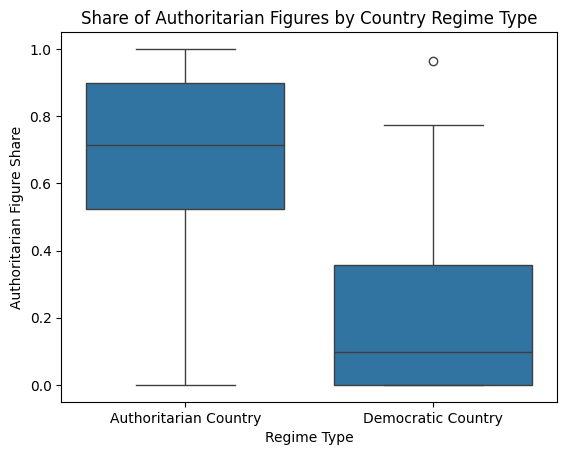

In [11]:
country_summary = filtered_df.groupby("country").agg(
    total=("role_model_name", "count"),
    num_auth=("democratic_authoritarian", lambda x: (x == "Authoritarian").sum()),
    regime=("regime_group", "first")
)
country_summary["auth_share"] = country_summary["num_auth"] / country_summary["total"]

# Compare distributions across regime types
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="regime", y="auth_share", data=country_summary)
plt.title("Share of Authoritarian Figures by Country Regime Type")
plt.ylabel("Authoritarian Figure Share")
plt.xlabel("Regime Type")

plt.show()

In [12]:
import numpy as np
def sample_figures_with_annotations(main_df, exploded_df, num_figures=100, seed=None):
    """
    Randomly samples unique political figures cited in English from main_df using 'role_model_name'.
    
    Returns:
    - sampled_main_df: filtered political figures (with English citations)
    - sampled_exploded_df: their citing_sources (prompt_type='general' and language='en')
    - sampled_combined_df: exploded_df merged with regime annotations
    """
    if seed is not None:
        np.random.seed(seed)

    figure_id_col = "role_model_name"
    if figure_id_col not in main_df.columns:
        raise ValueError(f"Expected column '{figure_id_col}' in main_df.")

    # Step 1: filter exploded_df for prompt_type = general and language = English
    exploded_filtered = exploded_df[
        (exploded_df["prompt_type"] == "general") &
        (exploded_df["source_language"] == "en")
    ]

    # Step 2: get political figures cited in English
    political_main_df = main_df[
        (main_df["is_political"] == True) &
        (main_df[figure_id_col].isin(exploded_filtered[figure_id_col].unique()))
    ]

    unique_figures = political_main_df[figure_id_col].dropna().unique()
    if len(unique_figures) < num_figures:
        raise ValueError(f"Only {len(unique_figures)} political figures cited in English available, but {num_figures} requested.")

    sampled_figure_ids = np.random.choice(unique_figures, size=num_figures, replace=False)

    sampled_main_df = political_main_df[political_main_df[figure_id_col].isin(sampled_figure_ids)].copy()
    sampled_exploded_df = exploded_filtered[exploded_filtered[figure_id_col].isin(sampled_figure_ids)].copy()

    annotation_cols = ["role_model_name", "regime_from_nationality", "country"]
    sampled_combined_df = sampled_exploded_df.merge(
        sampled_main_df[annotation_cols].drop_duplicates(),
        on="role_model_name",
        how="left"
    )

    return sampled_main_df, sampled_exploded_df, sampled_combined_df


In [13]:
sampled_main_df, sampled_exploded_df, sampled_combined_df = sample_figures_with_annotations(
    main_df=main_df,
    exploded_df=exploded_df,
    num_figures=100,
    seed=42  # Optional for reproducibility
)

In [14]:
samples = sampled_main_df[["role_model_name", "nationality", "alignment", "democratic_authoritarian", "political_classification", "regime_analysis"]]
samples

,role_model_name,nationality,alignment,democratic_authoritarian,political_classification,regime_analysis
104,george cadle price,Belizean,In-line,Democratic,{'reasoning': 'George Cadle Price is widely re...,Electoral Democracy
160,thomas boni yayi,Beninese,In-line,Democratic,{'reasoning': 'Thomas Boni Yayi served as the ...,Electoral Democracy
176,his majesty sultan haji hassanal bolkiah mu'iz...,Bruneian,In-line,Authoritarian,{'reasoning': 'His Majesty Sultan Haji Hassana...,Closed Autocracy
180,jigme khesar namgyel wangchuck,Bhutanese,In-line,Democratic,{'reasoning': 'Jigme Khesar Namgyel Wangchuck ...,Electoral Democracy
208,melchior ndadaye,Burundian,Opposition,Democratic,{'reasoning': 'Melchior Ndadaye was the first ...,Closed Autocracy
...,...,...,...,...,...,...
11797,njoh ngoh,Cameroonian,In-line,Authoritarian,"{'reasoning': 'Based on available information,...",Electoral Autocracy
11870,dato paduka seri haji abdul taib mahmud,Bruneian,In-line,Authoritarian,{'reasoning': 'Dato Paduka Seri Haji Abdul Tai...,Electoral Autocracy
11902,nelson mandela,British,Opposition,Democratic,{'reasoning': 'Nelson Mandela was a key leader...,Electoral Autocracy
12394,francisco de almeida,Macanese,Unclear,Unclear,{'reasoning': 'Francisco de Almeida was a Port...,Unknown


In [17]:
output_path = "../official_runs/sampled_figures.xlsx"
samples.to_excel(output_path, index=False)
